In [126]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style('darkgrid')
from collections import Counter

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

# Feature Selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Modeling
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from numpy import argmax

In [2]:
!pwd

/home/yon/Documents/Personal_Plan/Project_3_ChurnRatePrediction/projectChurnRate


Datasets:
* Dataset pre-processed: ./Data/df_preprocess_done.csv
* Dataset for prediction: ./Data/df_prediction.csv'

In [51]:
df = pd.read_csv('./Data/df_preprocess_done.csv', index_col=0)
print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head()

Size of the dataset:  20095
Number of variables: 29


,churn,age,purchases_partners,cc_application_begin,app_downloaded,web_user,android_user,left_for_two_month_plus,left_for_one_month,reward_rate,...,zodiac_sign_Cancer,zodiac_sign_Capricorn,zodiac_sign_Gemini,zodiac_sign_Leo,zodiac_sign_Libra,zodiac_sign_Pisces,zodiac_sign_Sagittarius,zodiac_sign_Scorpio,zodiac_sign_Taurus,zodiac_sign_Virgo
user,,,,,,,,,,,,,,,,,,,,,
50488,0,-1.343601,0.337098,0.363497,0.225574,-1.241151,0.839206,-0.459087,-0.139761,-0.617441,...,0,0,0,0,0,0,0,0,0,1
53603,0,0.824089,0.299623,-0.096405,0.225574,-1.241151,0.839206,-0.459087,-0.139761,-0.307211,...,0,0,0,0,0,0,1,0,0,0
42289,1,1.064943,-0.449882,-0.249706,0.225574,0.805704,0.839206,-0.459087,-0.139761,-0.361164,...,0,0,0,0,0,0,0,0,0,0
4185,0,0.342380,-0.749683,-0.249706,0.225574,0.805704,-1.191603,-0.459087,-0.139761,1.581146,...,0,0,0,0,0,0,0,1,0,0
12436,1,-0.861892,0.674375,0.210196,0.225574,0.805704,0.839206,-0.459087,-0.139761,-0.226281,...,0,0,0,0,0,0,0,1,0,0


# 4. Modeling

1. Separate dataset 
    - For X and y classes. 
    - Split dataset for training and testing.
2. Feature Selection
    - Use linear regression model
    - Use ...
3. Modeling for finding the best:
    - Model creation with pipeline
    - GridSearchCV for finding the best parameters of each model
    - Model Calibration using best parameters



In [ ]:
clf_stats_df = pd.DataFrame(columns=["clf_name", "F1-score", "auc-score", "elapsed_time"])

## 1. Separate dataset for X and y classes.

In [52]:
X = df.drop('churn', axis = 1)
y = df['churn']
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))


X shape: (20095, 28)
y shape: (20095,)


In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10)
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_train shape: (14066, 28)
y_train shape: (14066,)
x_test shape: (6029, 28)
y_test shape: (6029,)


In [57]:
x_train.columns, y_train.name

(Index(['age', 'purchases_partners', 'cc_application_begin', 'app_downloaded',
        'web_user', 'android_user', 'left_for_two_month_plus',
        'left_for_one_month', 'reward_rate', 'is_referred', 'housing_O',
        'housing_R', 'payment_type_Bi-Weekly', 'payment_type_Monthly',
        'payment_type_Semi-Monthly', 'payment_type_Weekly',
        'zodiac_sign_Aquarius', 'zodiac_sign_Aries', 'zodiac_sign_Cancer',
        'zodiac_sign_Capricorn', 'zodiac_sign_Gemini', 'zodiac_sign_Leo',
        'zodiac_sign_Libra', 'zodiac_sign_Pisces', 'zodiac_sign_Sagittarius',
        'zodiac_sign_Scorpio', 'zodiac_sign_Taurus', 'zodiac_sign_Virgo'],
       dtype='object'),
 'churn')

In [6]:
# Update numerical and categorical values for later modeling. Without consider churn variable

cat_features = df.select_dtypes(exclude = np.number).columns
num_features = df.select_dtypes(include = np.number).columns
num_features = num_features[1:]
print( "Quantity of Categorical features: ", len(cat_features),"\nCategorical features: ", cat_features)
print( "\nQuantity of Numerical features: ", len(num_features),"\nNumerical features: ", num_features)

Quantity of Categorical features:  3 
Categorical features:  Index(['housing', 'payment_type', 'zodiac_sign'], dtype='object')

Quantity of Numerical features:  10 
Numerical features:  Index(['age', 'purchases_partners', 'cc_application_begin', 'app_downloaded',
       'web_user', 'android_user', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred'],
      dtype='object')


In [7]:
# Pipeline:

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore'))])	

churn_trans = ColumnTransformer( transformers=[  ('numerical', num_transformer, num_features)  ,('categorical', cat_transformer, cat_features)])

In [8]:
# Parameters that pipeline can accepts:

num_transformer.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'imputer', 'scaler', 'imputer__add_indicator', 'imputer__copy', 'imputer__fill_value', 'imputer__missing_values', 'imputer__strategy', 'imputer__verbose', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std'])

In [38]:
x_train_transformed = churn_trans.fit(x_train).get_feature_names_out
x_test_transformed = churn_trans.fit_transform(x_test)
x_train_transformed

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'purchases_partners', 'cc_application_begin', 'app_downloaded',
       'web_user', 'android_user', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['hou

TypeError: 'method' object is not subscriptable

## 2. Feature Selection

### 2.1. Using Linear Regression Model

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

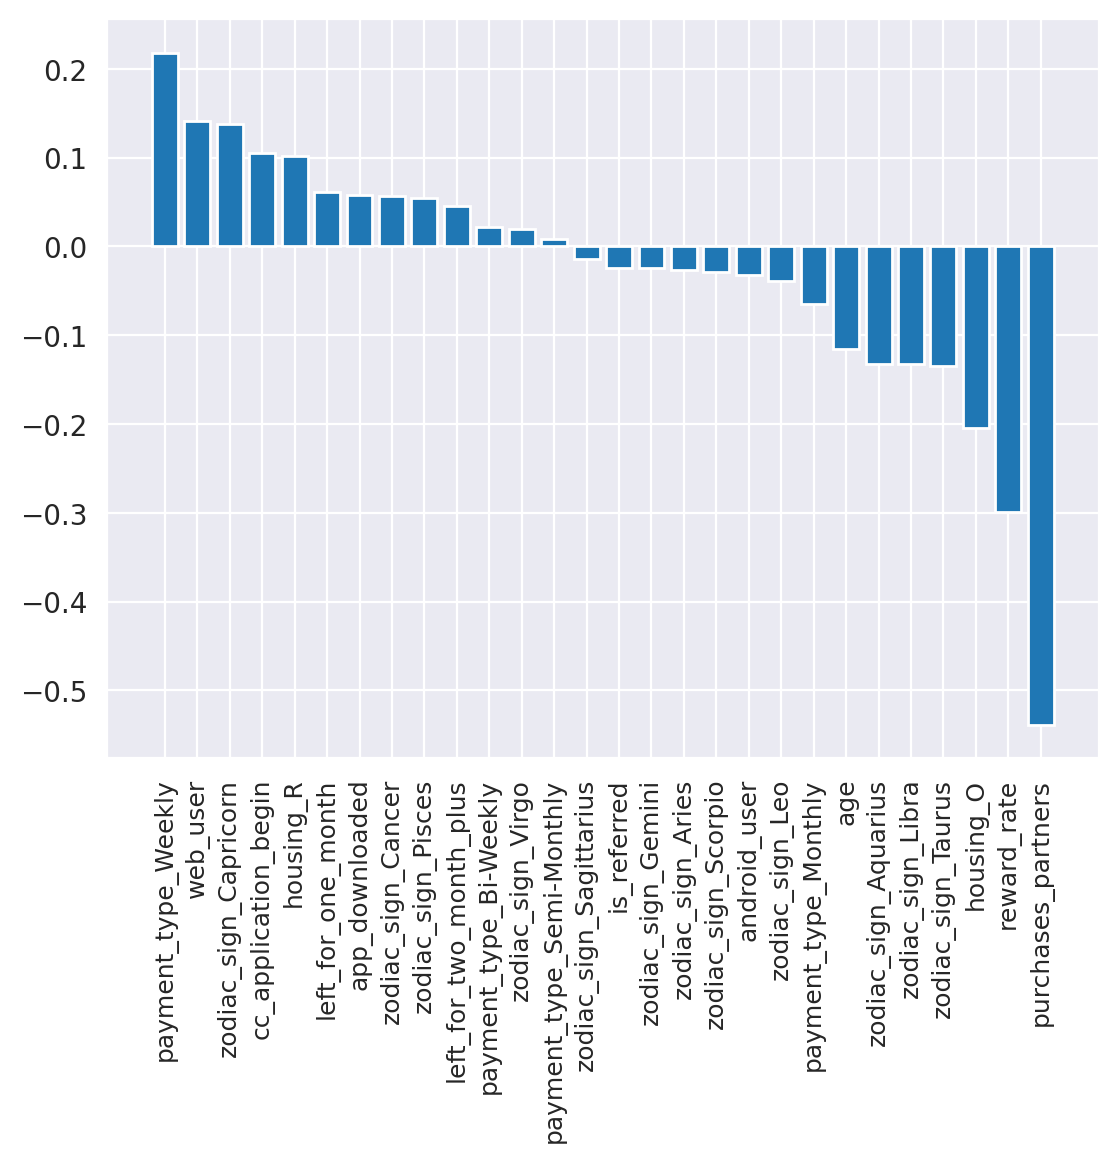

In [188]:
log_rg = LogisticRegression().fit(x_train, y_train)

feature_importance_lr = pd.DataFrame(zip(x_train.columns.values, log_rg.coef_.ravel()))
feature_importance_lr.columns = ['feature', 'coef']
feature_importance_lr.sort_values("coef", ascending=False, inplace=True)
plt.bar(feature_importance_lr['feature'], feature_importance_lr['coef'])
plt.xticks(rotation=90, fontsize=9)

In [189]:
feature_importance_lr.where((feature_importance_lr["coef"] < -0.1)|(feature_importance_lr["coef"] > 0.1)).dropna()

,feature,coef
15,payment_type_Weekly,0.218114
4,web_user,0.141701
19,zodiac_sign_Capricorn,0.138131
2,cc_application_begin,0.104899
11,housing_R,0.102298
0,age,-0.115398
16,zodiac_sign_Aquarius,-0.132261
22,zodiac_sign_Libra,-0.132862
26,zodiac_sign_Taurus,-0.134872
10,housing_O,-0.204395


In [140]:
feature_logistic = list(feature_importance_lr.where((feature_importance_lr["coef"] < -0.1)|(feature_importance_lr["coef"] > 0.1)).dropna()['feature'].values)
print("More important features with coef < -0.1 and coef > 0.1: \n", "There is a {} features from {}".format(len(feature_logistic), x_train.shape[1]) )
feature_logistic

More important features with coef < -0.1 and coef > 0.1: 
 There is a 12 features from 28


['payment_type_Weekly',
 'web_user',
 'zodiac_sign_Capricorn',
 'cc_application_begin',
 'housing_R',
 'age',
 'zodiac_sign_Aquarius',
 'zodiac_sign_Libra',
 'zodiac_sign_Taurus',
 'housing_O',
 'reward_rate',
 'purchases_partners']

Using this model, the more important features with coef < -0.1 and coef > 0.1. There is a 12 features from 28. We can see that the more important variables are:

- 'payment_type_Weekly',
- 'web_user',
- 'zodiac_sign_Capricorn',
- 'cc_application_begin',
- 'housing_R',
- 'age',
- 'zodiac_sign_Aquarius',
- 'zodiac_sign_Libra',
- 'zodiac_sign_Taurus',
- 'housing_O',
- 'reward_rate',
- 'purchases_partners'

In [212]:
lr_support_num = feature_importance_lr["coef"].values
lr_support = np.where((lr_support>0.1)|(lr_support < -0.1), True, False)
lr_support

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True])

As a number of features, we will calculate the best 12 features using other methods. Later, we will sum up and then calculate the most importants.

In [223]:
num_feats = 12

### 2.2. Using Recursive Feature Elimination (RFE) as wrapped method

In [138]:
# Number of features as 12
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=12, step=10, verbose=5)
rfe_selector.fit(x_train, y_train)
rfe_support = rfe_selector.get_support()
feature_rfe = x_train.loc[:,rfe_support].columns.tolist()
print(str(len(feature_rfe)), 'selected features')
print(feature_rfe)

Fitting estimator with 28 features.
Fitting estimator with 18 features.
12 selected features
['age', 'purchases_partners', 'cc_application_begin', 'web_user', 'reward_rate', 'housing_O', 'housing_R', 'payment_type_Weekly', 'zodiac_sign_Aquarius', 'zodiac_sign_Capricorn', 'zodiac_sign_Libra', 'zodiac_sign_Taurus']


In [139]:
feature_rfe

['age',
 'purchases_partners',
 'cc_application_begin',
 'web_user',
 'reward_rate',
 'housing_O',
 'housing_R',
 'payment_type_Weekly',
 'zodiac_sign_Aquarius',
 'zodiac_sign_Capricorn',
 'zodiac_sign_Libra',
 'zodiac_sign_Taurus']

In [203]:
rfe_support

array([ True,  True,  True, False,  True, False, False, False,  True,
       False,  True,  True, False, False, False,  True,  True, False,
       False,  True, False, False,  True, False, False, False,  True,
       False])

### 2.3. Using Random Forest as embeded method

In [160]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=12)
embeded_rf_selector.fit(x_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
feature_embeded_rf = x_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(feature_embeded_rf)), 'selected features')
feature_embeded_rf

4 selected features


['age', 'purchases_partners', 'cc_application_begin', 'reward_rate']

In [202]:
embeded_rf_support

array([ True,  True,  True, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

### 2.4. Using mutual info classif as entropy method

<AxesSubplot:>

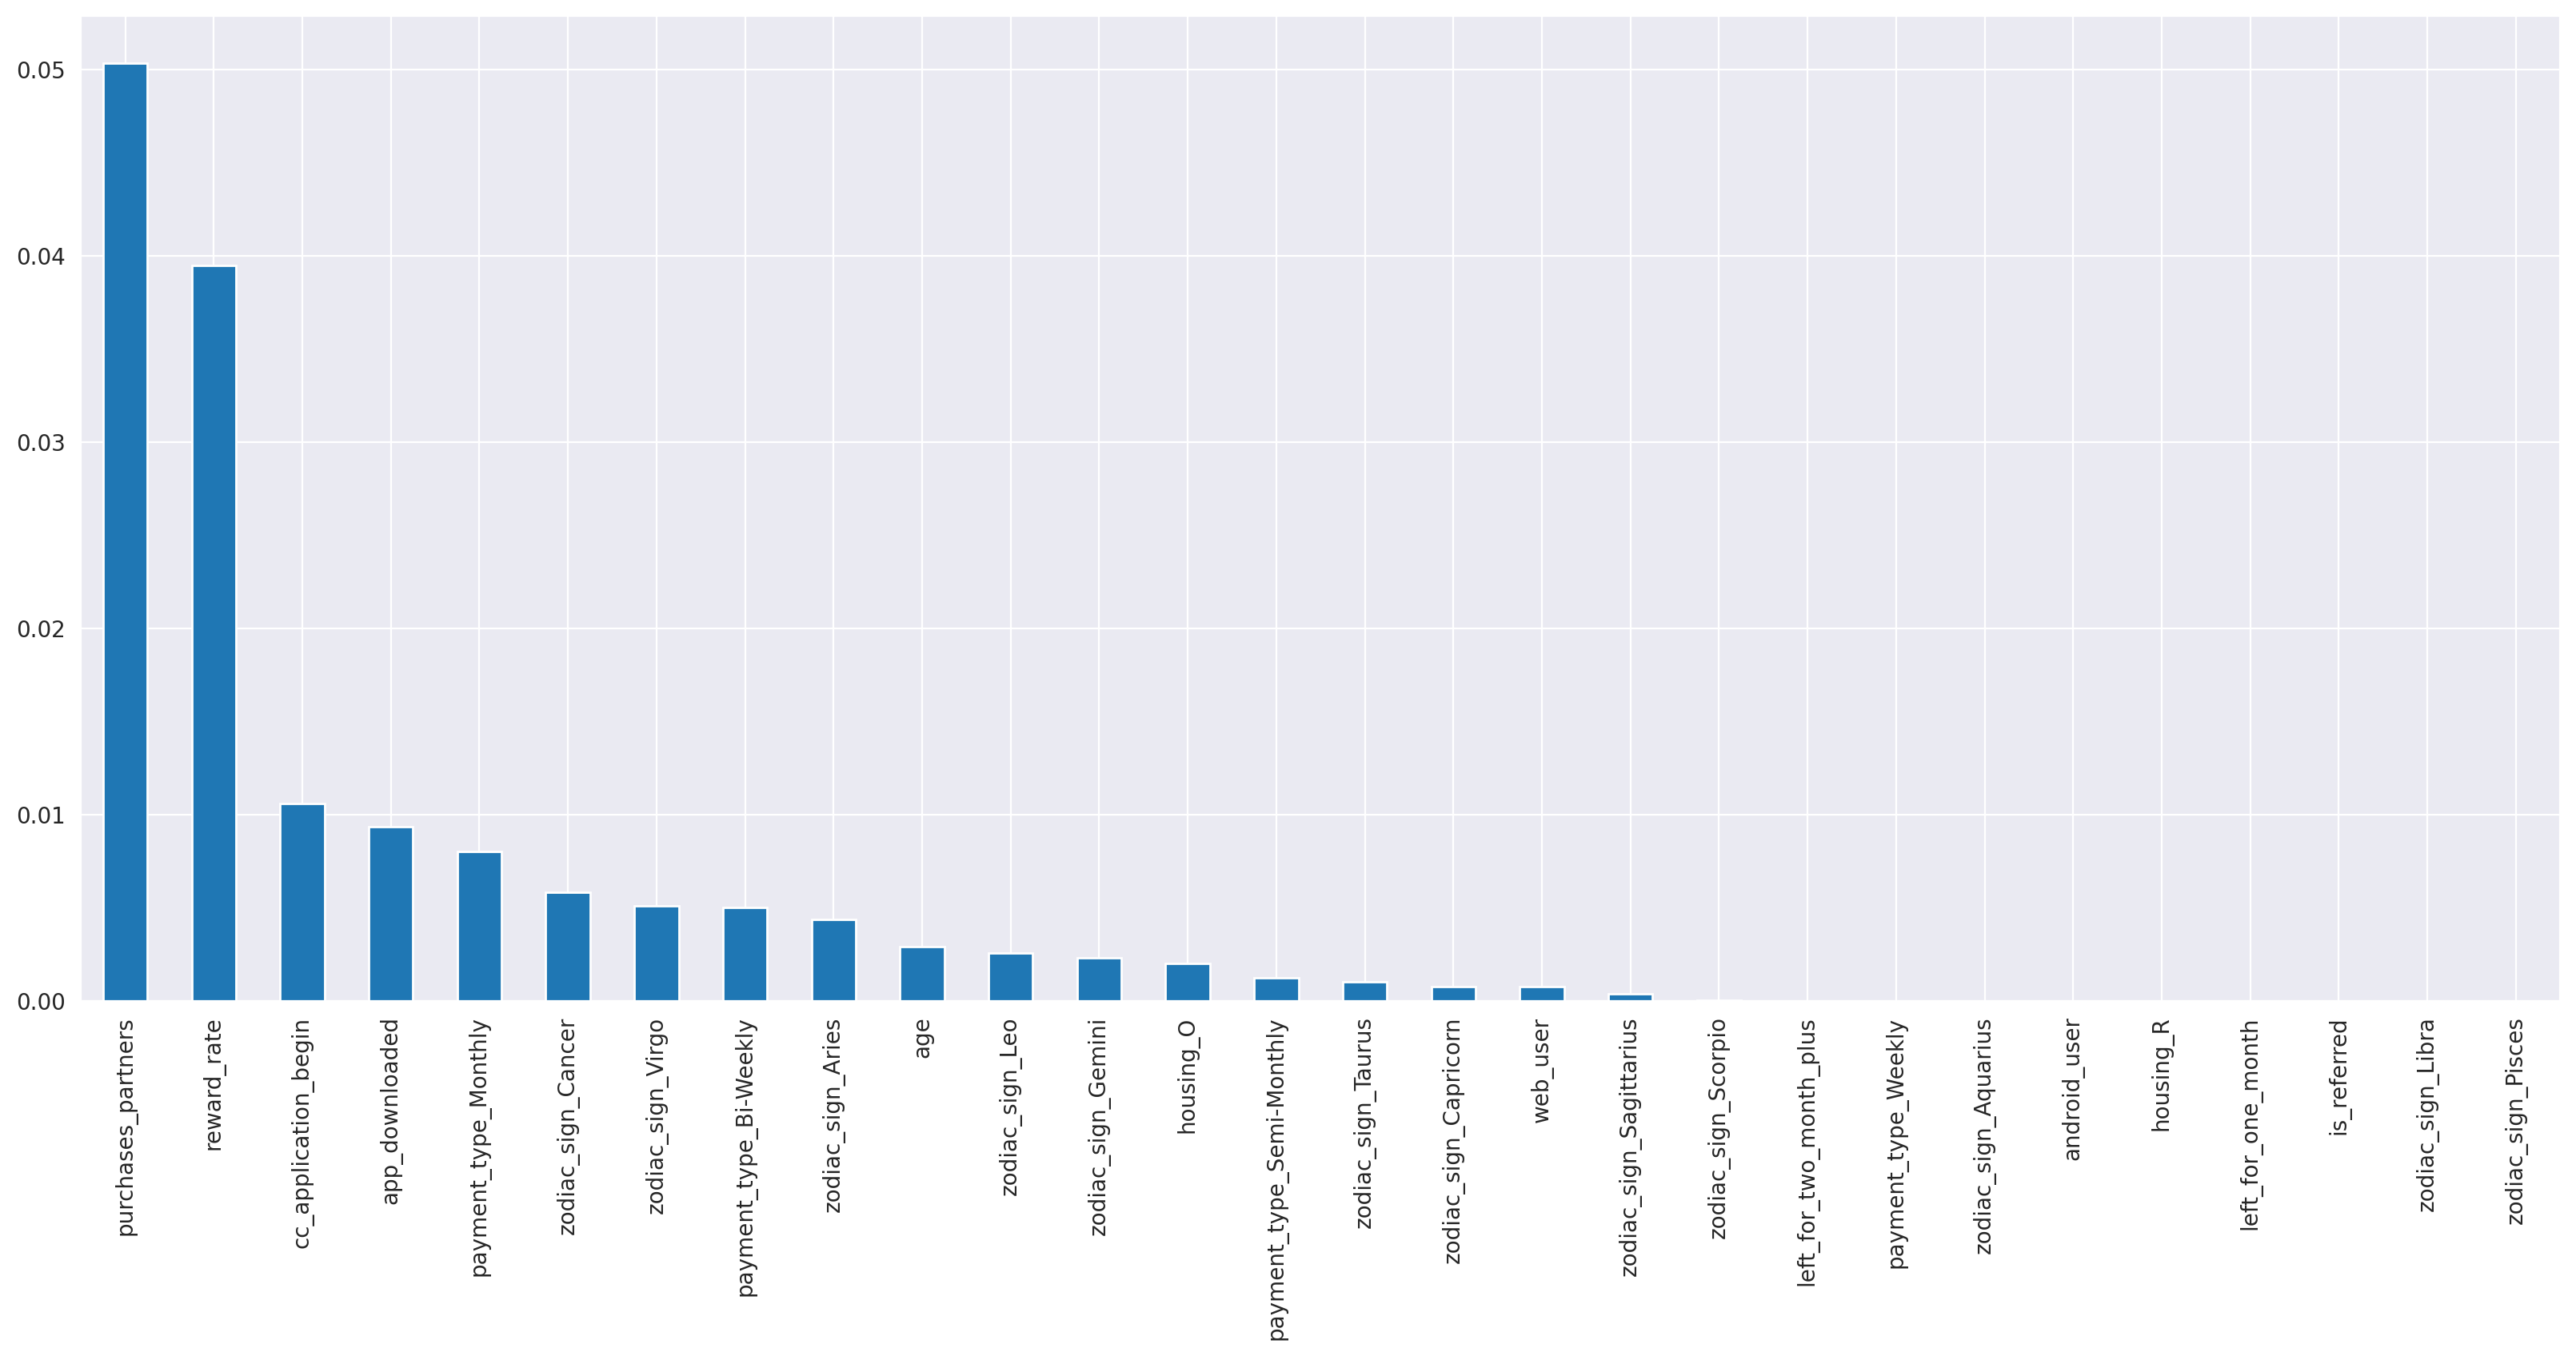

In [178]:
importances =  mutual_info_classif(x_train,y_train)
feature_mutual_importance = pd.Series(importances, index = x_train.columns)
feature_mutual_importance.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [206]:
feature_mutual_importance.where(feature_mutual_importance > 0.0023).sort_values(ascending=False).dropna()

purchases_partners        0.050351
reward_rate               0.039495
cc_application_begin      0.010583
app_downloaded            0.009362
payment_type_Monthly      0.008036
zodiac_sign_Cancer        0.005815
zodiac_sign_Virgo         0.005116
payment_type_Bi-Weekly    0.005005
zodiac_sign_Aries         0.004383
age                       0.002900
zodiac_sign_Leo           0.002561
zodiac_sign_Gemini        0.002309
dtype: float64

In [187]:
feature_mutual = list(feature_mutual_importance.where(feature_mutual_importance > 0.0023).sort_values(ascending=False).dropna().index)
print("The more important features are: \n")
feature_mutual

The more important features are: 



['purchases_partners',
 'reward_rate',
 'cc_application_begin',
 'app_downloaded',
 'payment_type_Monthly',
 'zodiac_sign_Cancer',
 'zodiac_sign_Virgo',
 'payment_type_Bi-Weekly',
 'zodiac_sign_Aries',
 'age',
 'zodiac_sign_Leo',
 'zodiac_sign_Gemini']

In [213]:
mutual_support = np.where(importances > 0.0023, True, False)
mutual_support

array([ True,  True,  True,  True, False, False, False, False,  True,
       False, False, False,  True,  True, False, False, False,  True,
        True, False,  True,  True, False, False, False, False, False,
        True])

### 3.5. Sum up and putting all together

In [224]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':x_train.columns, 
                                     'Logistics':lr_support,
                                     'RFE':rfe_support,
                                     'Random Forest':embeded_rf_support, 'Mutual Classif':mutual_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
# feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Logistics,RFE,Random Forest,Mutual Classif,Total
1,purchases_partners,True,True,True,True,4
2,cc_application_begin,True,True,True,True,4
0,age,True,True,True,True,4
8,reward_rate,False,True,True,True,3
27,zodiac_sign_Virgo,True,False,False,True,2
26,zodiac_sign_Taurus,True,True,False,False,2
22,zodiac_sign_Libra,True,True,False,False,2
21,zodiac_sign_Leo,True,False,False,True,2
4,web_user,True,True,False,False,2
3,app_downloaded,True,False,False,True,2


In [229]:
new_num_features = list(feature_selection_df['Feature'][0:12].values)
print("Here the most important features we will use for modeling:\n")
new_num_features

Here the most important features we will use for modeling:



['purchases_partners',
 'cc_application_begin',
 'age',
 'reward_rate',
 'zodiac_sign_Virgo',
 'zodiac_sign_Taurus',
 'zodiac_sign_Libra',
 'zodiac_sign_Leo',
 'web_user',
 'app_downloaded',
 'zodiac_sign_Scorpio',
 'zodiac_sign_Sagittarius']

## 4. Modeling for finding the best:
- Model creation with pipeline
- GridSearchCV for finding the best parameters of each model
- Model Calibration using best parameters

### 4.1 Logistic Regresion Model

In [10]:
# Logistic Regresion Model

logr_model = LogisticRegression();
churn_pipe_logr = Pipeline(steps = [('prep', churn_trans), ('clas',logr_model)])

In [21]:
# GridSearchCV for logistic Regression

parameters = {}
parameters['prep__numerical__imputer__strategy'] = ['mean', 'median']
#parameters['clas__C'] = [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
parameters['clas__C'] = np.logspace(-3,3,10) 
parameters['clas__class_weight'] = [None, 'balanced']
parameters['clas__penalty'] = ["l1","l2",'elasticnet']
parameters['clas__solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag']


GS = GridSearchCV(churn_pipe_logr, parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5)
GS.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'purchases_partners', 'cc_application_begin', 'app_downloaded',
       'web_user', 'android_user', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred'],
      dty...
             param_grid={'clas__C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e

In [22]:
print("Mejor score: ", GS.best_score_)
print("Mejor configuración de parámetros: ", GS.best_params_)

churn_pipe_logr = GS.best_estimator_

Mejor score:  0.5951338842987538
Mejor configuración de parámetros:  {'clas__C': 0.001, 'clas__class_weight': None, 'clas__penalty': 'l2', 'clas__solver': 'newton-cg', 'prep__numerical__imputer__strategy': 'mean'}


In [142]:
#building a dataframe from cross-validation data
#df_cv_scores=pd.DataFrame(GS.cv_results_).sort_values(by='rank_test_score')
df_cv_scores=pd.DataFrame(GS.cv_results_)
print(df_cv_scores.columns)
df_cv_scores.head()

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clas__C', 'param_clas__class_weight', 'param_clas__penalty',
       'param_prep__numerical__imputer__strategy', 'params',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'split3_test_recall',
       'split4_test_recall', 'mean_test_recall', 'std_test_recall',
       'rank_test_recall'],
      dtype='object')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clas__C,param_clas__class_weight,param_clas__penalty,param_prep__numerical__imputer__strategy,params,split0_test_accuracy,...,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.078219,0.097963,0.000000,0.000000,0.001,None,l1,mean,"{'clas__C': 0.001, 'clas__class_weight': None,...",NaN,...,NaN,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42
1,0.022117,0.001018,0.000000,0.000000,0.001,None,l1,median,"{'clas__C': 0.001, 'clas__class_weight': None,...",NaN,...,NaN,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93
2,0.085987,0.090639,0.012811,0.000615,0.001,None,l2,mean,"{'clas__C': 0.001, 'clas__class_weight': None,...",0.634103,...,0.010338,1,0.489157,0.479133,0.470305,0.473896,0.477912,0.47808,0.006353,39
3,0.047234,0.001551,0.012871,0.000217,0.001,None,l2,median,"{'clas__C': 0.001, 'clas__class_weight': None,...",0.634103,...,0.010338,1,0.489157,0.479133,0.470305,0.473896,0.477912,0.47808,0.006353,39
4,0.024262,0.001221,0.000000,0.000000,0.001,None,elasticnet,mean,"{'clas__C': 0.001, 'clas__class_weight': None,...",NaN,...,NaN,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92


In [ ]:
#selecting specific columns to create a view
df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
       'split3_test_score', 'split4_test_score', 'mean_test_score',\
       'std_test_score', 'rank_test_score']].head()

In [13]:

def show_results(y, y_pred):
    from sklearn.metrics import confusion_matrix


    # COMPLETAR
    c_mat = confusion_matrix(y, y_pred)


    sns.heatmap(c_mat, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados: ")
    print(f'\taccuracy: { accuracy_score(y, y_pred) :.3f}')
    print(f'\trecall: { recall_score(y, y_pred, average="macro") :.3f}')
    print(f'\tprecision: { precision_score(y, y_pred, average="macro") :.3f}')
    print(f'\tf1_score: { f1_score(y, y_pred, average="macro") :.3f}')

In [23]:
#checking how well the model does on the holdout-set
GS.score(x_test,y_test)

0.5818264014466547

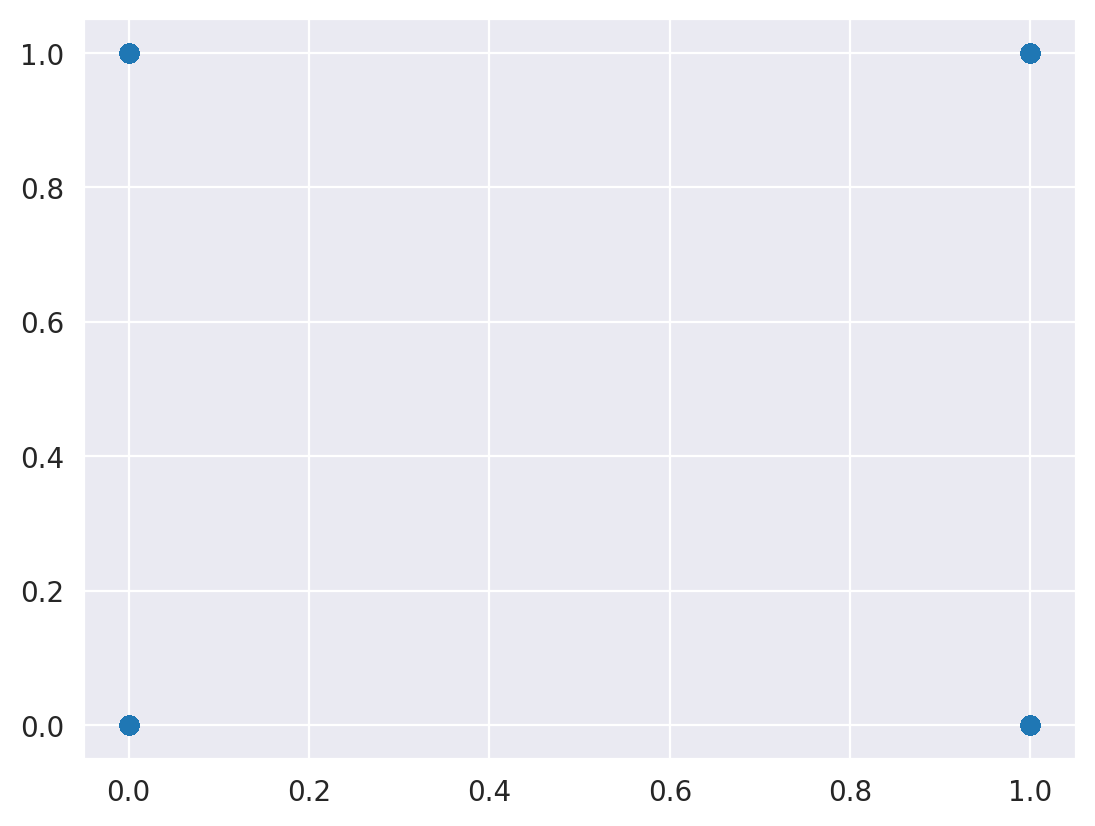

In [24]:
#plotting predicted body weights vs actual body weights of penguins
y_preds=GS.predict(x_test)
plt.scatter(y_test,y_preds);

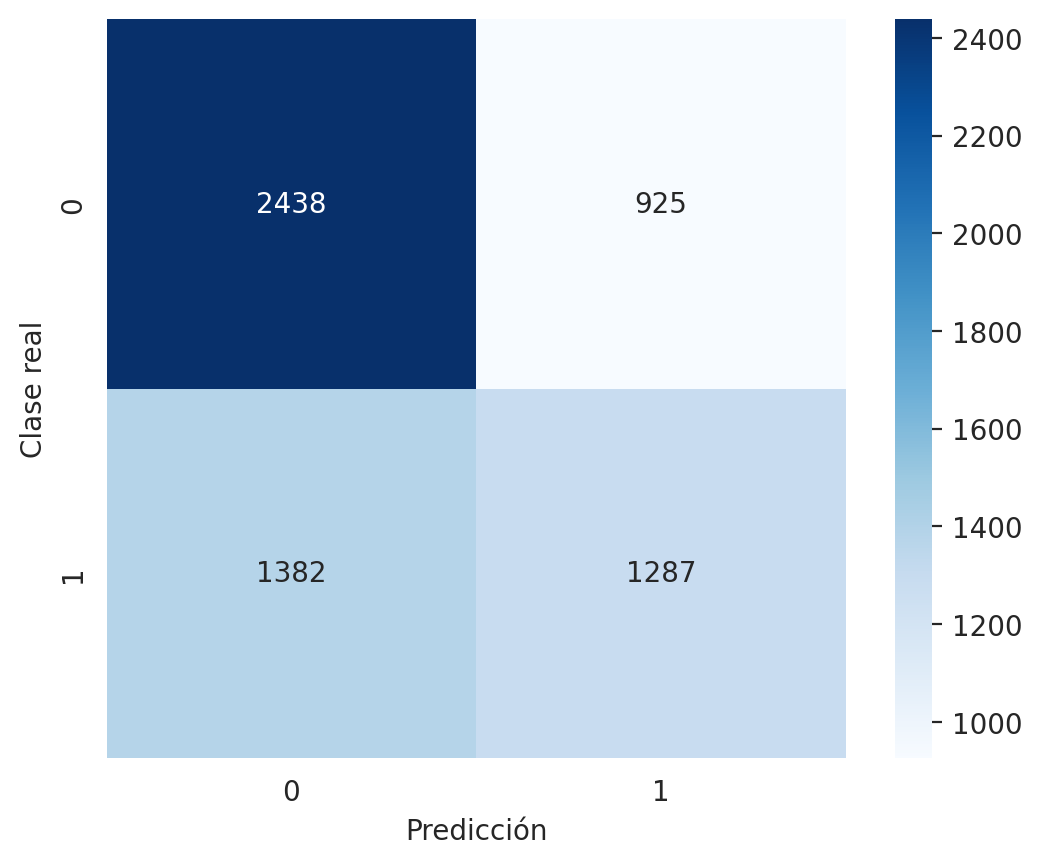

Resultados: 
	accuracy: 0.618
	recall: 0.604
	precision: 0.610
	f1_score: 0.603


In [26]:
y_pred = GS.predict(x_test)
show_results(y_test, y_pred)


In [27]:
y_prob = churn_pipe_logr.predict_proba(X)[:,1]

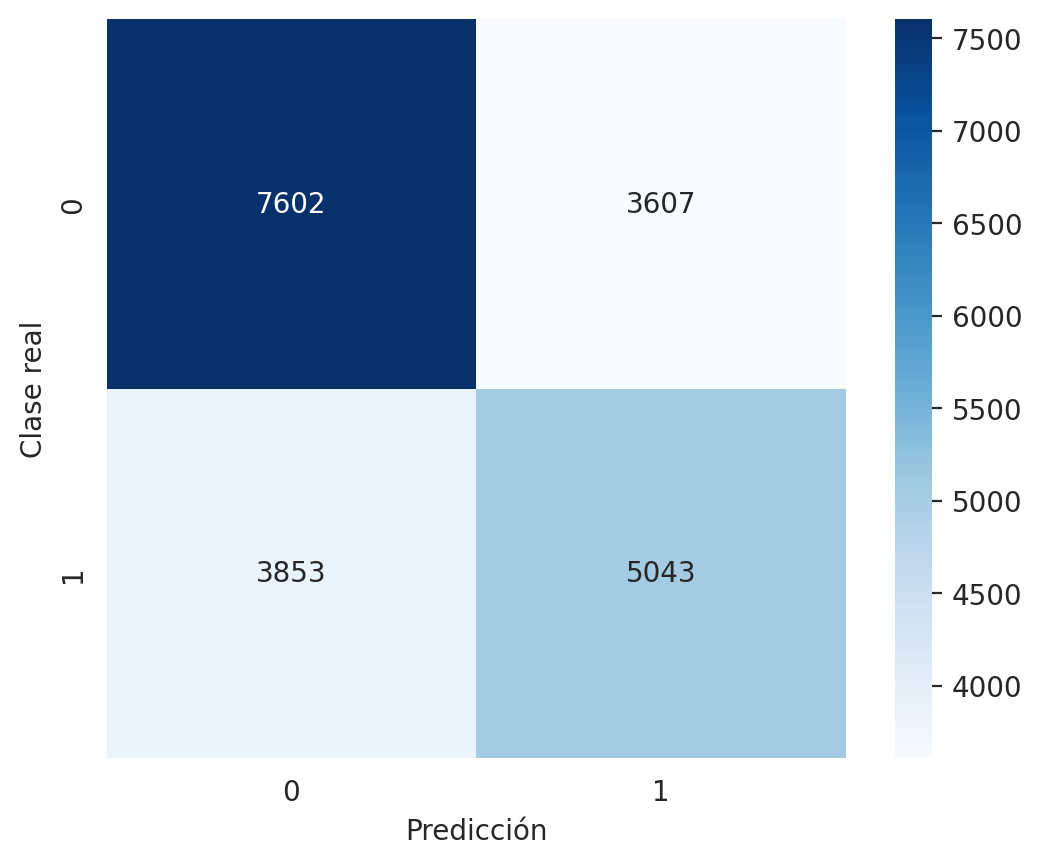

Resultados: 
	accuracy: 0.629
	recall: 0.623
	precision: 0.623
	f1_score: 0.623


In [28]:
y_pred = y_prob >= 0.48
show_results(y, y_pred)

Best Threshold=0.374921, F-Score=0.640
Umbrales considerados: 		 [0.1236 0.127  0.1271 ... 0.7008 0.7009 0.7052]
Predicciones (valores únicos):   [0.0931 0.1057 0.1086 ... 0.7008 0.7009 0.7052]


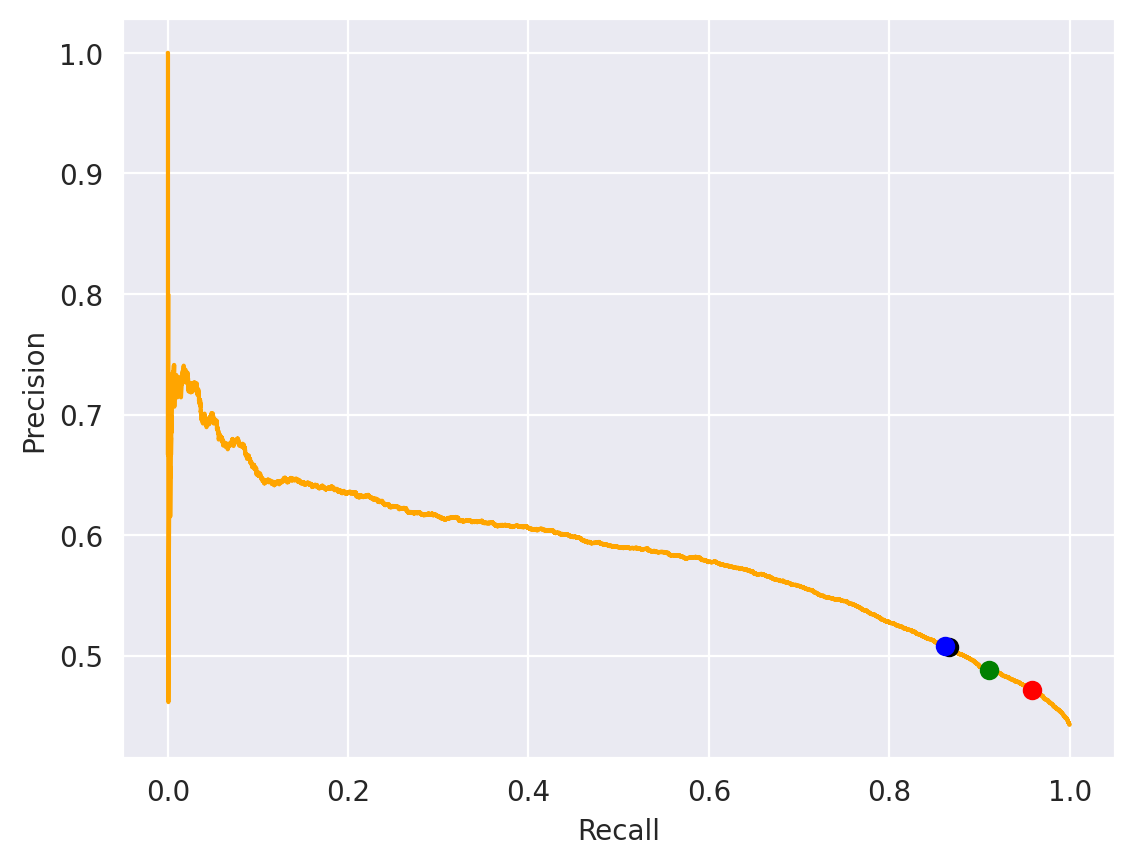

In [19]:
# COMPLETAR

precision, recall, thresholds = precision_recall_curve(y, y_prob)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.plot(recall, precision, color='orange')
plt.plot(recall[ix],precision[ix], marker='o', color='black'); # mejor threshold


plt.plot(recall[2000],precision[2000], 'or'); # Umbral = 0.227, rojo
plt.plot(recall[3500],precision[3500], 'og'); # Umbral = 0.5, verde
plt.plot(recall[5000],precision[5000], 'ob'); # Umbral = 0.805, azul
plt.xlabel('Recall')
plt.ylabel('Precision');

print("Umbrales considerados: \t\t", np.round(thresholds,4))
print("Predicciones (valores únicos):  ", np.round(np.unique(y_prob),4))

In [20]:
argmax(fscore), thresholds

(4896,
 array([0.12355507, 0.12698987, 0.12712489, ..., 0.70083956, 0.70090752,
        0.70518065]))

### 4.1 Decision Tree Model

Mejor score:  0.6433930645864024
Mejor configuración de parámetros:  {'clas__class_weight': None, 'clas__max_depth': 5, 'prep__numerical__imputer__strategy': 'mean'}


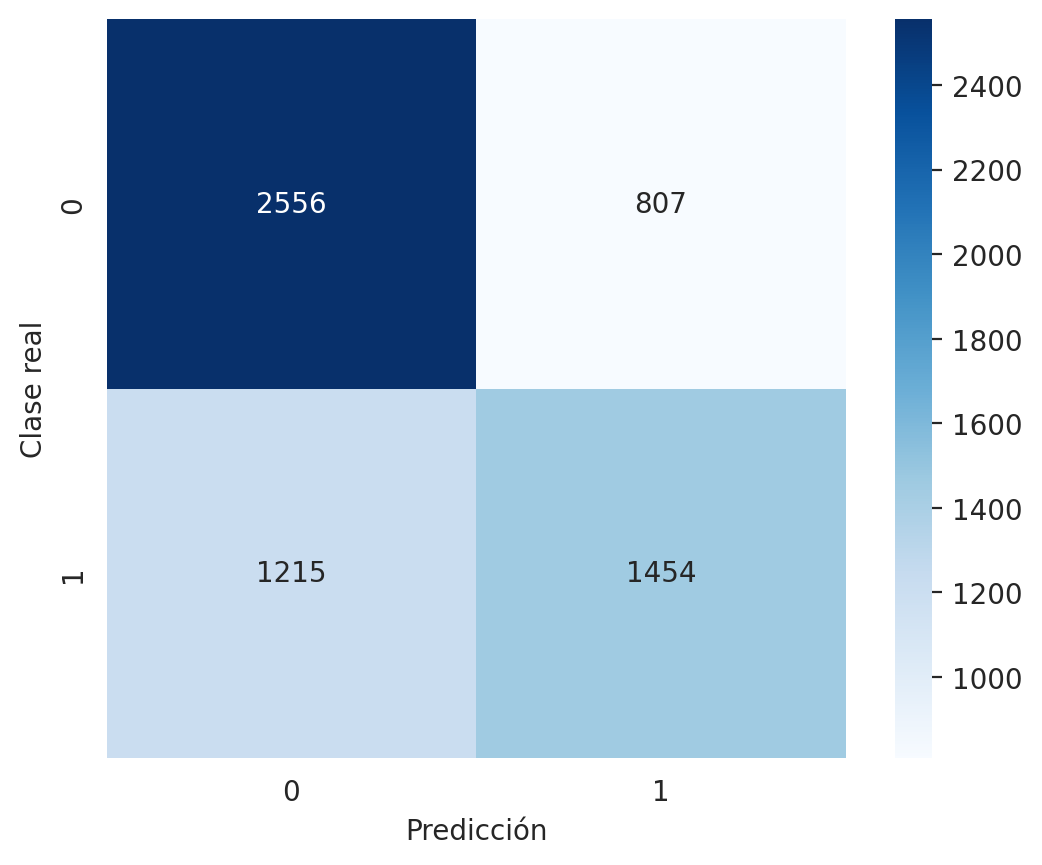

Resultados: 
	accuracy: 0.665
	recall: 0.652
	precision: 0.660
	f1_score: 0.653


In [77]:
dt_model = DecisionTreeClassifier();


# COMPLETAR
churn_pipe_tree = Pipeline(steps = [('prep', churn_trans), ('clas',dt_model)])


parameters = {}
parameters['prep__numerical__imputer__strategy'] = ['mean', 'median']
parameters['clas__max_depth'] = [None, 3, 5, 7, 9]
parameters['clas__class_weight'] = [None, 'balanced']


#
# COMPLETAR
#
GS = GridSearchCV(churn_pipe_tree, parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5)
GS.fit(x_train, y_train)

print("Mejor score: ", GS.best_score_)
print("Mejor configuración de parámetros: ", GS.best_params_)

churn_pipe_tree = GS.best_estimator_

#
# COMPLETAR
#
y_pred = GS.predict(x_test)
show_results(y_test, y_pred)

In [78]:
y_prob = churn_pipe_tree.predict_proba(x_test)[:,1]

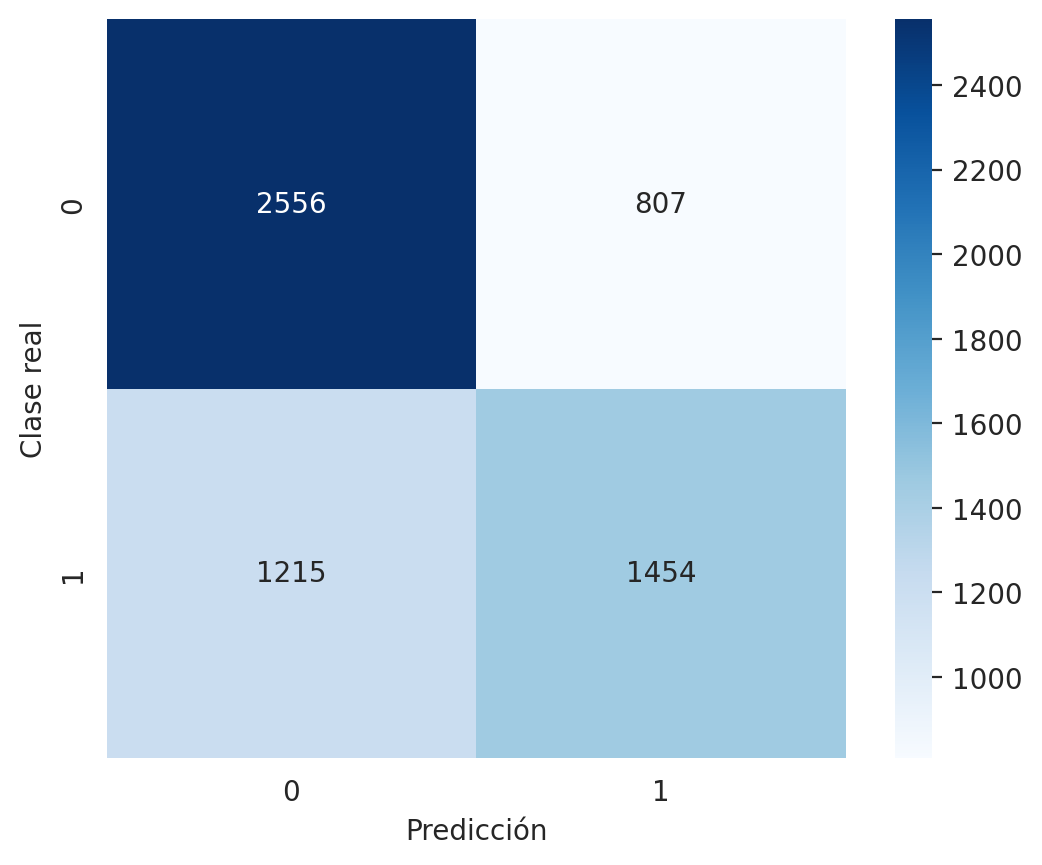

Resultados: 
	accuracy: 0.665
	recall: 0.652
	precision: 0.660
	f1_score: 0.653


In [84]:
y_pred = y_prob >= 0.47
show_results(y_test, y_pred)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.plot(recall, precision, color='orange')
plt.plot(recall[ix],precision[ix], marker='o', color='black'); # mejor threshold


plt.xlabel('Recall')
plt.ylabel('Precision');

print("Umbrales considerados: \t\t", np.round(thresholds,4))
#print("Predicciones (valores únicos):  ", np.round(np.unique(y_prob),4))

In [90]:
 thresholds

array([False,  True])

### 4.3. SVM Model

In [ ]:

svm_model = SVC(probability=True);


# COMPLETAR
churn_pipe_svc = Pipeline(steps = [('prep', churn_trans), ('clas',svm_model)])


parameters = {}
parameters['prep__numerical__imputer__strategy'] = ['mean', 'median']
parameters['clas__C'] = [10e-2, 1, 100]
parameters['clas__kernel'] = ['linear', 'rbf']


#
# COMPLETAR
#
GS = GridSearchCV(churn_pipe_svc, parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5)
GS.fit(x_train, y_train)


print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

churn_pipe_svc = GS.best_estimator_

#
# COMPLETAR
#
y_pred = GS.predict(x_test)
show_results(y_test, y_pred)
